# Preprocessing of Data (train.csv)
This processes train.csv into train_subset.csv, which will be fed to the models.

## Imports

In [3]:
import pandas as pd
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing

In [4]:
CSV_IN = "input/original_data.csv"   # Original data file
CSV_OUT = "output/tfidf_dataset.csv" # Output file
RNG = 42                             # Random seed

# Load the full CSV
df = pd.read_csv(CSV_IN)

# Print the original dataframe
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


(159571, 2)
cyberbullying
0    143346
1     16225
Name: count, dtype: int64
                                        comment_text  cyberbullying
0  Explanation\nWhy the edits made under my usern...              0
1  D'aww! He matches this background colour I'm s...              0
2  Hey man, I'm really not trying to edit war. It...              0
3  "\nMore\nI can't make any real suggestions on ...              0
4  You, sir, are my hero. Any chance you remember...              0
5  "\n\nCongratulations from me as well, use the ...              0
6       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK              1
7  Your vandalism to the Matt Shirvington article...              0
8  Sorry if the word 'nonsense' was offensive to ...              0
9  alignment on this subject and which are contra...              0


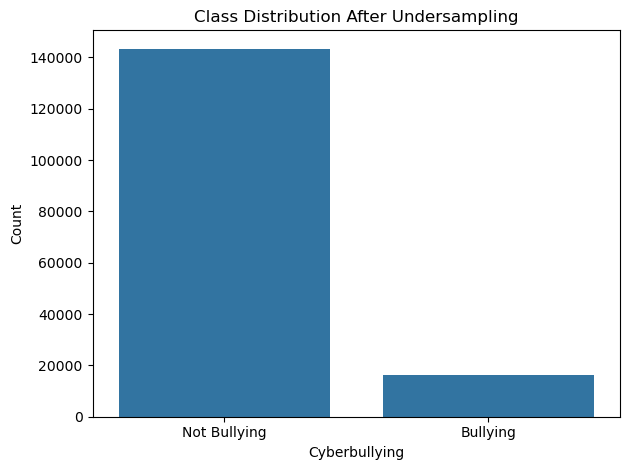

In [ ]:
# List of cyberbullying-related columns
cyberbullying_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Add new column that is 1 if any of the specified columns is 1
df['cyberbullying'] = df[cyberbullying_cols].max(axis=1)

# Drop the original individual label columns if not needed
df = df.drop(columns=cyberbullying_cols)

# Drop the unneeded id column
df = df.drop(columns=['id'])

# Print the updated dataframe
print(df.shape)
print(df.value_counts("cyberbullying"))
print(df.head(10))
# Plot class distribution
sns.countplot(x='cyberbullying', data=df)
plt.title('Class Distribution BEFORE Undersampling')
plt.xlabel('Cyberbullying')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Bullying', 'Bullying'])
plt.tight_layout()
plt.show()

## Undersampling
We notice that there is a discrepancy between the number of cyberbullying comments and non-cyberbullying comments in our dataset. About 90% of our dataset is comprised of non-cyberbullying comments, whereas the remaining 10% is cyberbullying. We attempt to address this using undersamping: 

cyberbullying
0    16225
1    16225
Name: count, dtype: int64
                                             comment_text  cyberbullying
43242   We want to keep the first sentence of the lead...              0
44937   WHO CARES.... GOETHEAN IS A capuchin monkeys a...              1
151831  yes i would say the book source is enough to a...              0
128030  Thanks for your help.  I guess I will have to ...              0
61287            Then do the same for the tiger accounts.              0
119140  He is a symbol of contentment hence he is cont...              1
17762   "\n\nNow thats funny vandalism\nI wonder who w...              1
28159   I didn't say you favored him over me, I said y...              1
135296  Message for Antandrus vandals administrator   ...              0
119639                 "or ""king crowned"" (enlightend)"              0


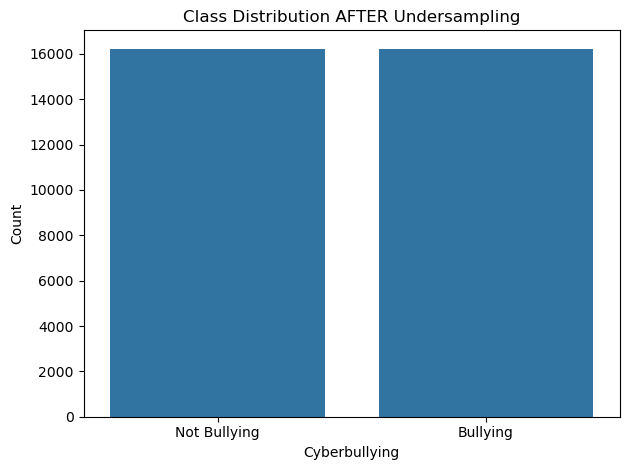

In [6]:
# Separate majority and minority classes
df_majority = df[df.cyberbullying == 0] # Majority -> non-cyberbullying
df_minority = df[df.cyberbullying == 1] # Minority -> cyberbullying

# Downsample majority class
# By randomly selecting a subset of majority samples equal in size to the minority class	
df_majority_downsampled = resample(
    df_majority,
    replace=False,               # sample without replacement
    n_samples=len(df_minority),  # to match minority class
    random_state=RNG             # reproducibility
)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the resulting dataset, preserving original indexing
df_balanced = df_balanced.sample(frac=1, random_state=RNG)

# Print new class balance
print(df_balanced['cyberbullying'].value_counts())
print(df_balanced.head(10))
# Plot class distribution
sns.countplot(x='cyberbullying', data=df_balanced)
plt.title('Class Distribution AFTER Undersampling')
plt.xlabel('Cyberbullying')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Bullying', 'Bullying'])
plt.tight_layout()
plt.show()

### tf-idf

In [147]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,  # limit vocabulary size
    stop_words='english', # filter out common words that typically do not carry significant meaning in text analysis, such as "the," "a," "is,"
    lowercase=True, # Convert to lowercase before tokenizing
    token_pattern = u'(?ui)\\b(?=\\w*[a-z])\\w{3,}\\b', # At least 3 characters, and at least one letter
    min_df=2,                  # Ignore terms that appear in fewer than 2 docs
    ngram_range=(1, 2),        # Use unigrams and bigrams (e.g., "shut up")
)

# Apply TF-IDF on the 'comment_text' column
X_tfidf = vectorizer.fit_transform(df_balanced['comment_text'])

# Convert to DataFrame for saving
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_balanced.index  # preserve original index
)

# Append the binary label
tfidf_df['cyberbullying'] = df_balanced['cyberbullying'].values
tfidf_df.head(5)

,10th,12th,15th,16th,1960s,19th,19th century,1px,1px solid,1st,...,zealand,zero,zionist,zoe,zone,zoo,zuck,zuckerberg,ŷour,cyberbullying
43242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
44937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
151831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
128030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
61287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Verify that tfidf worked

In [148]:
# Show non-zero TF-IDF features and original comment text for the first 10 rows
for idx in range(10):
    original_idx = df_balanced.index[idx]  # index in the original df
    original_comment = df.loc[original_idx, 'comment_text']
    
    tfidf_row = tfidf_df.iloc[idx].drop('cyberbullying')
    non_zero_features = tfidf_row[tfidf_row > 0]
    
    label = df_balanced.loc[original_idx, 'cyberbullying']
    print(f"Comment: {original_comment}")
    print("Non-zero TF-IDF features:")
    print(non_zero_features)
    print('-' * 80)

Comment: We want to keep the first sentence of the lead concise.  We can list all the CRs at the end of the lead or in a separate section.  Listing the white CRs makes it appear they are more important.  But Jamaica has almost the same population as NZ while Barbados is the oldest realm and at one time the most important.
Non-zero TF-IDF features:
appear              0.206094
concise             0.292262
end                 0.187842
important           0.360378
lead                0.409229
list                0.165821
listing             0.245198
makes               0.178040
oldest              0.292262
population          0.233417
section             0.156410
sentence            0.201040
separate            0.226230
separate section    0.300445
time                0.127401
want                0.133052
white               0.200010
Name: 43242, dtype: float64
--------------------------------------------------------------------------------
Comment: WHO CARES.... GOETHEAN IS A capuchin mo

## Output to file

In [149]:
# Save final dataset for ML modeling
tfidf_df.to_csv(CSV_OUT, index=False)
print(f"TF-IDF dataset saved to {CSV_OUT}")

TF-IDF dataset saved to output/tfidf_dataset.csv
